1. TEXT PRE PROCESSING - TOKENIZATION, STOP WORDS REMOVAL, STEMMING.
2. MAKING WORD VECTORS WITH WORD2VEC.
3. CONVERTING COLUMNS TO VECTORS.
4. GENERATING CUSTOM FEATURES.
5. PERFORMING OVERSAMPLING DUE TO CLASS IMBALANCE.
6. TRAINING RANDOM FOREST CLASSIFIER, XG BOOST CLASSIFIER, RNN AND LSTM MODELS.
7. PERFORMANCE ANALYSIS
8. INFERENCE ON TEST


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import zipfile

In [30]:
import gensim
from gensim.models import Word2Vec,KeyedVectors
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

<span style="font-size:20px">Exploratory Data Analysis</span>


In [31]:
data = pd.read_csv("train.csv")
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [32]:
data["is_duplicate"].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [33]:
data.dropna(inplace = True)

<span style="font-size:20px">MAKING CORPUS AND CLEANING THE TEXT</span>

In [34]:
corpus = data['question1'].tolist() + data['question2'].tolist()
#corpus is now a list of all questions — first all question1, then all question2

story = []
for sent in tqdm(corpus):
    story.append(simple_preprocess(sent))#story becomes a list of tokenized sentences (a list of word lists)

100%|████████████████████████████████| 808574/808574 [00:10<00:00, 74611.99it/s]


In [35]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

stemmer = PorterStemmer()
def process_word_list(word_list):
    meaningful_words = [
        stemmer.stem(word)  # Apply stemming
        for word in word_list
        if word.lower() not in stopwords.words("english")  # Remove stopwords
    ]
    return meaningful_words

cleaned_story = [process_word_list(sublist) for sublist in tqdm(story)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|█████████████████████████████████| 808574/808574 [09:20<00:00, 1441.65it/s]


<span style="font-size:20px">Word2Vec</span>

In [36]:
word2vec_model = gensim.models.Word2Vec(window = 5, min_count = 2, vector_size=30)
word2vec_model.build_vocab(cleaned_story)
word2vec_model.train(cleaned_story,
            total_examples = word2vec_model.corpus_count,
            epochs = word2vec_model.epochs)

(20498081, 21715385)

In [37]:
data["Ques1_Cleaned"] = cleaned_story[:len(data)]
data["Ques2_Cleaned"] = cleaned_story[len(data):]

In [38]:
sample_data = data.copy() # INITIALLY USED FOR TAKING SAMPLES OUT OF MAIN DATA
sample_data.reset_index(inplace = True, drop = True)

<span style="font-size:20px">GENERATING CUSTOM FEATURES USING TEXT BLOB</span>

- AVG WORD LENGTH  
- WORD COUNT  
- AVG SENTENCE LENGTH  
- FOG INDEX  
- COMPLEX WORD COUNT


In [39]:
from textblob import TextBlob

def text_analysis(word_list):
    # Join the list of words into a text string
    text = " ".join(word_list)

    # Create a TextBlob object
    blob = TextBlob(text)

    # Sentiment Analysis
    polarity_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity

    # Word Metrics
    word_count = len(word_list)
    average_word_length = sum(len(word) for word in word_list) / word_count

    # Sentence Metrics
    sentence_count = len(blob.sentences)
    average_sentence_length = word_count / sentence_count

    # FOG Index
    complex_word_count = len([word for word in word_list if len(word) > 3])
    fog_index = 0.4 * (average_sentence_length + complex_word_count / word_count)

    return np.array([average_word_length, word_count, average_sentence_length, fog_index, complex_word_count])

<span style="font-size:20px">CONVERTING TEXT COLUMN INTO VECTORS</span>

In [46]:
# 1) Make sure TextBlob is installed
%pip install -q textblob

# 2) Download *exactly* the corpora TextBlob needs
from textblob import download_corpora
download_corpora.download_all()

# 3) Sanity‑check: should print a polarity / subjectivity tuple without errors
from textblob import TextBlob
print(TextBlob("It finally works!").sentiment)



vec1 = np.zeros((len(sample_data), 30))
vec2 = np.zeros((len(sample_data), 30))
other_features = np.zeros((len(sample_data), 10))

for i in tqdm(range(len(sample_data))):

    text1 = sample_data["Ques1_Cleaned"][i]
    text2 = sample_data["Ques2_Cleaned"][i]   #Word2Vec Vector Averaging

    if len(text1) != 0:
        vec1[i] = (sum([word2vec_model.wv[word] for word in text1 if word in word2vec_model.wv.index_to_key]) / len(text1))
        blob1 = text_analysis(text1)
    else:
        vec1[i] = np.zeros((30,))
        blob1 = np.zeros((5,))
    if len(text2) != 0:
        vec2[i] = (sum([word2vec_model.wv[word] for word in text2 if word in word2vec_model.wv.index_to_key]) / len(text2))
        blob2 = text_analysis(text2)
    else:
        vec2[i] = np.zeros((30,))
        blob2 = np.zeros((5,))
    other_features[i] = np.concatenate([blob1, blob2])


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Sentiment(polarity=0.0, subjectivity=1.0)


[nltk_data] Downloading package brown to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/ronaldriju/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
100%|█████████████████████████████████| 404287/404287 [03:17<

In [47]:
sample_data = pd.concat([sample_data,
                        pd.DataFrame(vec1, columns = np.arange(0, 30)),
                        pd.DataFrame(vec2, columns = np.arange(30, 60)),
                        pd.DataFrame(other_features, columns = np.arange(60, 70))], axis = 1)
sample_data

,id,qid1,qid2,question1,question2,is_duplicate,Ques1_Cleaned,Ques2_Cleaned,0,1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",-0.457389,-0.950082,...,4.857143,7.0,7.0,3.200000,7.0,4.833333,6.0,6.0,2.800000,6.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, koh, noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",0.028696,-0.631941,...,5.400000,5.0,5.0,2.320000,4.0,5.400000,10.0,10.0,4.360000,9.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",0.476042,-0.711223,...,5.500000,6.0,6.0,2.666667,4.0,5.200000,5.0,5.0,2.320000,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, math, divid]",0.698351,-1.951560,...,4.666667,3.0,3.0,1.600000,3.0,4.800000,5.0,5.0,2.400000,5.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",0.176075,0.018767,...,4.800000,10.0,10.0,4.320000,8.0,4.800000,5.0,5.0,2.400000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404282,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[mani, keyword, racket, program, languag, late...","[mani, keyword, perl, program, languag, latest...",0.643033,0.521733,...,6.285714,7.0,7.0,3.200000,7.0,6.000000,7.0,7.0,3.200000,7.0
404283,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[believ, life, death]","[true, life, death]",2.065604,-2.099378,...,5.000000,3.0,3.0,1.600000,3.0,4.333333,3.0,3.0,1.600000,3.0
404284,404287,537928,537929,What is one coin?,What's this coin?,0,"[one, coin]",[coin],2.110967,-0.411916,...,3.500000,2.0,2.0,1.000000,1.0,4.000000,1.0,1.0,0.800000,1.0
404285,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,"[approx, annual, cost, live, studi, uic, chica...","[littl, hairfal, problem, want, use, hair, sty...",0.434945,-0.387113,...,5.333333,9.0,9.0,3.955556,8.0,4.692308,13.0,13.0,5.476923,9.0


# OVERSAMPLING


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
xresampled, yresampled = smote.fit_resample(sample_data.iloc[:,8:], sample_data["is_duplicate"])
xresampled.shape, yresampled.shape

((510048, 70), (510048,))

# MODELING

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
xtrain, xtest, ytrain, ytest = train_test_split(xresampled, yresampled, test_size = 0.2)
xtrain.shape, ytrain.shape

((408038, 70), (408038,))

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(xtrain, ytrain)
rf_model.score(xtest, ytest)

0.8573767277717871

In [60]:
import xgboost as xg
xg_model = xg.XGBClassifier()
xg_model.fit(xtrain, ytrain)
xg_model.score(xtest, ytest)

0.8060680325458288

In [61]:
import joblib

joblib.dump(rf_model, 'rf_model.joblib')
joblib.dump(xg_model, 'xg_model.joblib')

['xg_model.joblib']

In [64]:
loaded_rf_model = joblib.load('rf_model.joblib')
loaded_xg_model = joblib.load('xg_model.joblib')

# PERFORMANCE ANALYSIS

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

ypred1 = rf_model.predict(xtest)
ypred2 = xg_model.predict(xtest)
conf_matrix1 = confusion_matrix(ytest, ypred1)
conf_matrix2 = confusion_matrix(ytest, ypred2)

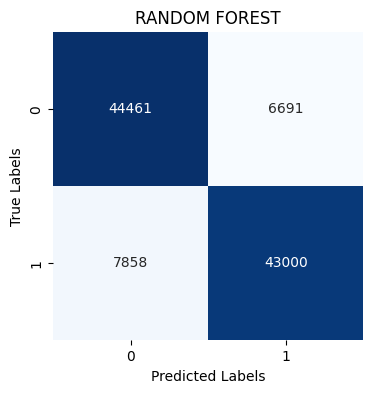

In [66]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RANDOM FOREST')
plt.show()

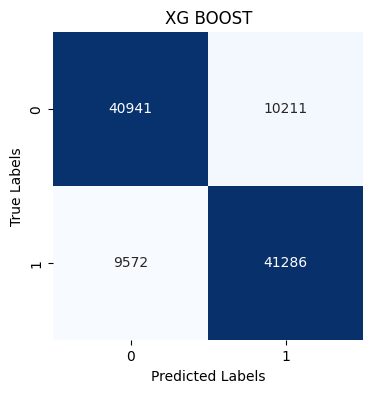

In [68]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d',cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XG BOOST')
plt.show()

In [69]:
class_report1 = pd.DataFrame(classification_report(ytest, ypred1, output_dict = True))
class_report2 = pd.DataFrame(classification_report(ytest, ypred2, output_dict = True))
class_report1

,0,1,accuracy,macro avg,weighted avg
precision,0.849806,0.865348,0.857377,0.857577,0.857555
recall,0.869194,0.845491,0.857377,0.857343,0.857377
f1-score,0.859391,0.855304,0.857377,0.857347,0.857353
support,51152.000000,50858.000000,0.857377,102010.000000,102010.000000


In [70]:
class_report2

,0,1,accuracy,macro avg,weighted avg
precision,0.810504,0.801717,0.806068,0.806110,0.806123
recall,0.800379,0.811790,0.806068,0.806084,0.806068
f1-score,0.805410,0.806722,0.806068,0.806066,0.806064
support,51152.000000,50858.000000,0.806068,102010.000000,102010.000000


# SAMPLE INFERENCE

## SINGLE PREDICTION

In [78]:
# sample1 = 'What are some common examples of solid matter?'
# sample2 = 'What are the most common examples of solid matter?'

l = 132433
sample1 = data["question1"][l]
sample2 = data["question2"][l]
sample1, sample2, data["is_duplicate"][l]

('How do prepare for IAS for a fresher?',
 'How should I prepare for IAS now?',
 1)

In [79]:
def inference(sample1, sample2):
    inf_text1 = process_word_list(sample1.split())
    inf_text2 = process_word_list(sample2.split())

    inf_vec1 = np.zeros((1, 30))
    inf_vec2 = np.zeros((1, 30))
    inf_other_features = np.zeros((1, 10))

    if len(inf_text1) != 0:
        inf_vec1[0] = (sum([word2vec_model.wv[word] for word in inf_text1 if word in word2vec_model.wv.index_to_key]) / len(inf_text1))
        inf_blob1 = text_analysis(inf_text1)
    else:
        inf_vec1[0] = np.zeros((30,))
        inf_blob1 = np.zeros((5,))
    if len(inf_text2) != 0:
        inf_vec2[0] = (sum([word2vec_model.wv[word] for word in inf_text2 if word in word2vec_model.wv.index_to_key]) / len(inf_text2))
        inf_blob2 = text_analysis(inf_text2)
    else:
        inf_vec2[0] = np.zeros((30,))
        inf_blob2 = np.zeros((5,))
    inf_other_features[0] = np.concatenate([inf_blob1, inf_blob2])

    inf_data = pd.DataFrame({})
    inf_data = pd.concat([inf_data,
                            pd.DataFrame(inf_vec1, columns = np.arange(0, 30)),
                            pd.DataFrame(inf_vec2, columns = np.arange(30, 60)),
                            pd.DataFrame(inf_other_features, columns = np.arange(60, 70))], axis = 1)
    return inf_data

inf_data = inference(sample1, sample2)
inf_data

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-1.011975,-0.248819,-1.16955,-1.109773,-0.201336,-0.371154,2.313023,1.029223,0.984344,-1.109913,...,5.333333,3.0,3.0,1.466667,2.0,4.0,3.0,3.0,1.466667,2.0


In [80]:
out = rf_model.predict(inf_data)

if out == 0:
    print("DIFFERENT")
else:
    print("DUPLICATE")

DUPLICATE


## PREDICTION ON SAMPLE DATA

In [84]:
sam = data.sample(10).iloc[:,3:6]
sam.reset_index(inplace = True, drop = True)
sam

,question1,question2,is_duplicate
0,Why does the US need Freddie Mac and Fannie Ma...,What is the future of Fannie Mae and Freddie Mac?,0
1,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,0
2,What will happen if someone decides to keep he...,How can I stop my friend from giving Coke/Peps...,0
3,Who are the likely Democrats to run in the 202...,Who are some Democrats who could run against T...,1
4,How accurately does Brooklyn Nine-Nine depict ...,How many episodes of Brooklyn nine nine season...,0
5,How can I achieve big things in life?,How do I achieve big things in life?,1
6,Is interface theory of perception accepted in ...,Is interface theory of perception by Donald Ho...,1
7,How much will you earn for 100 views on YouTub...,Who is the best YouTuber in the world?,0
8,Are there perks in Battlefield 4?,Are there perks in Battlefield 3?,0
9,What are some of the most controversial things...,What are some of the most controversial things...,0


In [85]:
outs = []
for k in range(len(sam)):
    sample1 = sam["question1"][k]
    sample2 = sam["question2"][k]
    inf_data = inference(sample1, sample2)
    outs.append(rf_model.predict(inf_data)[0])
sam["Predictions"] = outs
sam

,question1,question2,is_duplicate,Predictions
0,Why does the US need Freddie Mac and Fannie Ma...,What is the future of Fannie Mae and Freddie Mac?,0,0
1,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,0,0
2,What will happen if someone decides to keep he...,How can I stop my friend from giving Coke/Peps...,0,0
3,Who are the likely Democrats to run in the 202...,Who are some Democrats who could run against T...,1,1
4,How accurately does Brooklyn Nine-Nine depict ...,How many episodes of Brooklyn nine nine season...,0,0
5,How can I achieve big things in life?,How do I achieve big things in life?,1,1
6,Is interface theory of perception accepted in ...,Is interface theory of perception by Donald Ho...,1,1
7,How much will you earn for 100 views on YouTub...,Who is the best YouTuber in the world?,0,0
8,Are there perks in Battlefield 4?,Are there perks in Battlefield 3?,0,0
9,What are some of the most controversial things...,What are some of the most controversial things...,0,0


# RNN - DL APPROACH

## MAKING TOKENIZED SEQUENCES

In [89]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
xresampled_dl, yresampled_dl = ros.fit_resample(data.iloc[:,3:5], data["is_duplicate"])
xresampled_dl.shape, yresampled_dl.shape


((510048, 2), (510048,))

In [93]:
que1 = np.array(xresampled_dl['question1'].tolist())
que2 = np.array(xresampled_dl['question2'].tolist())

docx = []
for i in tqdm(range(len(que1))):
    docx.append(que1[i] + " " + que2[i])


100%|███████████████████████████████| 510048/510048 [00:03<00:00, 129329.43it/s]


In [94]:
lengths = []
for sent in tqdm(docx):
    lengths.append(len(sent.split()))

100%|███████████████████████████████| 510048/510048 [00:00<00:00, 751693.49it/s]


<Axes: ylabel='Density'>

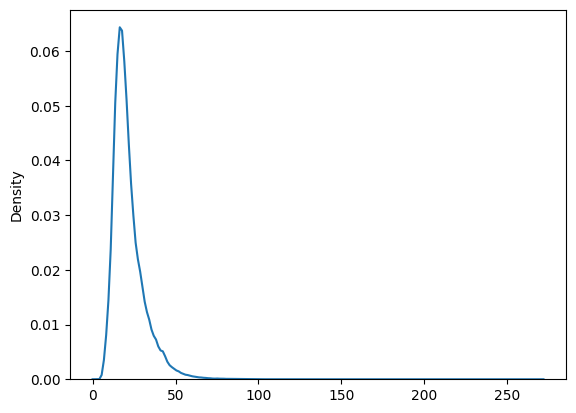

In [95]:
sns.kdeplot(lengths) # TO SEE, AROUND WHICH NUMBER THE MOST SENTENCE LENGHTS LIES


In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

# MODEL ARCHITECTURE

In [111]:

model = tf.keras.Sequential([tf.keras.Input(shape=(35,))])
model.add(tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, output_dim = 30))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 35, 30)         │     2,867,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 32)             │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,869,959 (10.95 MB)

 Trainable params: 2,869,959 (10.95 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])
history = model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20


2025-07-01 00:27:54.494888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


409/409 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.6903 - loss: 0.5851 - val_accuracy: 0.6117 - val_loss: 0.6718
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.7902 - loss: 0.4535 - val_accuracy: 0.8870 - val_loss: 0.3369
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.8244 - loss: 0.3901 - val_accuracy: 0.6168 - val_loss: 0.7007
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 597s 1s/step - accuracy: 0.8568 - loss: 0.3279 - val_accuracy: 0.8602 - val_loss: 0.3428
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.8796 - loss: 0.2820 - val_accuracy: 0.8840 - val_loss: 0.3056
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.8976 - loss: 0.2444 - val_accuracy: 0.9700 - val_loss: 0.1189
Epoch 7/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.9058 - loss: 0.2258 - val_accuracy: 0.8856 - val_loss: 0.2758
Epoch 8/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.9213 - loss: 0.1926 - val_accuracy: 0.975

In [128]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential

max_seq_length = 35
vocab_size = len(tokenizer.word_index) + 1   # +1 for the OOV/zero token

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(35,)),               # 35‑token sentence
    tf.keras.layers.Embedding(vocab_size, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),   # return_sequences=False
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")    # (batch, 1)
])

lstm_model.compile(loss="binary_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

lstm_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 35, 100)        │     9,559,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,644,309 (36.79 MB)

 Trainable params: 9,644,309 (36.79 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Assuming `tokenizer` is your already fitted Tokenizer object
num_tokens = len(tokenizer.word_counts)
print("Number of tokens:", num_tokens)

Number of tokens: 95595


In [130]:
history2 = lstm_model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.7121 - loss: 0.5595 - val_accuracy: 0.6092 - val_loss: 0.7177
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 903s 2s/step - accuracy: 0.7825 - loss: 0.4560 - val_accuracy: 0.7422 - val_loss: 0.4844
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.8091 - loss: 0.4016 - val_accuracy: 0.7456 - val_loss: 0.5152
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 882s 2s/step - accuracy: 0.8368 - loss: 0.3478 - val_accuracy: 0.8877 - val_loss: 0.3197
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.8591 - loss: 0.3050 - val_accuracy: 0.7923 - val_loss: 0.4399
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 941s 2s/step - accuracy: 0.8779 - loss: 0.2678 - val_accuracy: 0.8813 - val_loss: 0.3030
Epoch 7/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.8942 - loss: 0.2359 - val_accuracy: 0.8821 - val_loss: 0.2958
Epoch 8/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.9054 - loss: 0.2120 - val_accu

# INFERENCE

In [131]:
def inference_dl(sam1, sam2):
    docx = [sam1 + " " + sam2]
    sequences = tokenizer.texts_to_sequences(docx)
    sequences = pad_sequences(sequences, padding = "post", maxlen = 35)
    return sequences

In [132]:
l = 13243
sample1 = data["question1"][l]
sample2 = data["question2"][l]
sample1, sample2, data["is_duplicate"][l]

('Which one is grammatically correct: "an year" or "a year"?',
 'The atmosphere seem to be that of a friendly one. Is this phrase grammatically correct?',
 0)

In [135]:
sample1 = "Who is the most liked character of all time"
sample2 = 'Which character is the most liked in india'

In [136]:
inf_data = inference_dl(sample1, sample2)
out = lstm_model.predict(inf_data, verbose = 0)
out = tf.squeeze(out)
out = "DUPLICATE" if np.mean(out) >= 0.5 else "DIFFERENT"
out

'DIFFERENT'

In [137]:
sam = data.sample(10).iloc[:,3:6]
sam.reset_index(inplace = True, drop = True)
sam

,question1,question2,is_duplicate
0,What is the difference between microprocessor ...,Will the liberal Supreme Court justices be pre...,0
1,Who did the Greyjoys support during Robert's R...,Where were the Greyjoys during Robert's Rebell...,1
2,What are dreams really? Why don't we remember ...,Why don't we remember dreams after waking up?,1
3,Will my children develop schizophrenia?,"i have boyfriend, his family is schizophrenic,...",1
4,What are the works of general contractor?,What are the works of a general contractor?,1
5,What are some unexpected things first-time vis...,What are some unexpected things first-time vis...,0
6,What should I do to get a 5 on an AP exam with...,Is it possible to get a 5 on AP Physics 2 with...,0
7,What is the contribution of agriculture in Ind...,When can I file my income tax return in India ...,0
8,Why many of the Indians use the phrase when so...,"What are the origins of the Hindi phrase ""Majb...",1
9,What is the difference between a stock and a s...,Is there any difference between share and stock?,1


In [138]:
outs = []
for k in range(len(sam)):
    sample1 = sam["question1"][k]
    sample2 = sam["question2"][k]
    inf_data = inference_dl(sample1, sample2)
    out = lstm_model.predict(inf_data, verbose = 0)
    out = tf.squeeze(out)
    out = 1 if np.mean(out) >= 0.5 else 0
    outs.append(out)
sam["Predictions"] = outs
sam

,question1,question2,is_duplicate,Predictions
0,What is the difference between microprocessor ...,Will the liberal Supreme Court justices be pre...,0,0
1,Who did the Greyjoys support during Robert's R...,Where were the Greyjoys during Robert's Rebell...,1,1
2,What are dreams really? Why don't we remember ...,Why don't we remember dreams after waking up?,1,1
3,Will my children develop schizophrenia?,"i have boyfriend, his family is schizophrenic,...",1,1
4,What are the works of general contractor?,What are the works of a general contractor?,1,1
5,What are some unexpected things first-time vis...,What are some unexpected things first-time vis...,0,0
6,What should I do to get a 5 on an AP exam with...,Is it possible to get a 5 on AP Physics 2 with...,0,0
7,What is the contribution of agriculture in Ind...,When can I file my income tax return in India ...,0,0
8,Why many of the Indians use the phrase when so...,"What are the origins of the Hindi phrase ""Majb...",1,1
9,What is the difference between a stock and a s...,Is there any difference between share and stock?,1,1


In [140]:
model.save("my_model.keras")  


In [142]:


from tensorflow.keras.models import load_model
model1 = load_model("my_model.keras")


/Users/ronaldriju/ImageClassification/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
